# Copy of Previous RNN

### Reminders:

Read up on some of these:
- https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
- https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html 
- https://github.com/keras-team/keras/issues/5714
- https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/

###Shuffle Data!!!!!

"An issue with LSTMs is that they can easily overfit training data, reducing their predictive skill."
https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Pre-processing

## Do Basic Imports

In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import pandas
from matplotlib import pyplot as plt
from math import isnan
from scipy.stats import norm

pandas.set_option('display.max_columns', None)
np.set_printoptions(suppress=True, precision=3)

## Obtain data

In [2]:
# read data from drive
# csv_train = pandas.read_csv("drive/MyDrive/first_10k.csv")
# csv_train = pandas.read_csv("first_10k.csv")
csv_train = pandas.read_csv("FDC_tracks.csv") # n entries read how many
# csv_train = pandas.read_csv("drive/MyDrive/FDC_tracks.csv")
# unparsed_train = np.array(csv_train)

In [4]:
csv_train = csv_train[csv_train.columns.drop(list(csv_train.filter(regex=("sin"))))]
csv_train = csv_train[csv_train.columns.drop(list(csv_train.filter(regex=("cos"))))]

csv_train = csv_train[csv_train["rms"] < 0.1]
csv_train = csv_train[csv_train["t_tof_valid"] == 1]
csv_train = csv_train[csv_train["tanl"] < 100]
csv_train = csv_train[csv_train["chisq"]/csv_train["Ndof"] < 5]

In [37]:
csv_train.head()

,event,q_over_pt,phi,tanl,D,z,cov_00,cov_01,cov_02,cov_03,cov_04,cov_10,cov_11,cov_12,cov_13,cov_14,cov_20,cov_21,cov_22,cov_23,cov_24,cov_30,cov_31,cov_32,cov_33,cov_34,cov_40,cov_41,cov_42,cov_43,cov_44,invcov_00,invcov_01,invcov_02,invcov_03,invcov_04,invcov_10,invcov_11,invcov_12,invcov_13,invcov_14,invcov_20,invcov_21,invcov_22,invcov_23,invcov_24,invcov_30,invcov_31,invcov_32,invcov_33,invcov_34,invcov_40,invcov_41,invcov_42,invcov_43,invcov_44,chisq,Ndof,rms,t_start_cntr,t_start_cntr_valid,t_tof,t_tof_valid,t_bcal,t_bcal_valid,t_fcal,t_fcal_valid,hit1_u,hit1_v,hit1_s,hit1_ds,hit1_wire,hit1_glayer,hit1_z,hit1_time,hit1_dE_amp,hit1_q,hit2_u,hit2_v,hit2_s,hit2_ds,hit2_wire,hit2_glayer,hit2_z,hit2_time,hit2_dE_amp,hit2_q,hit3_u,hit3_v,hit3_s,hit3_ds,hit3_wire,hit3_glayer,hit3_z,hit3_time,hit3_dE_amp,hit3_q,hit4_u,hit4_v,hit4_s,hit4_ds,hit4_wire,hit4_glayer,hit4_z,hit4_time,hit4_dE_amp,hit4_q,hit5_u,hit5_v,hit5_s,hit5_ds,hit5_wire,hit5_glayer,hit5_z,hit5_time,hit5_dE_amp,hit5_q,hit6_u,hit6_v,hit6_s,hit6_ds,hit6_wire,hit6_glayer,hit6_z,hit6_time,hit6_dE_amp,hit6_q,hit7_u,hit7_v,hit7_s,hit7_ds,hit7_wire,hit7_glayer,hit7_z,hit7_time,hit7_dE_amp,hit7_q,hit8_u,hit8_v,hit8_s,hit8_ds,hit8_wire,hit8_glayer,hit8_z,hit8_time,hit8_dE_amp,hit8_q,hit9_u,hit9_v,hit9_s,hit9_ds,hit9_wire,hit9_glayer,hit9_z,hit9_time,hit9_dE_amp,hit9_q,hit10_u,hit10_v,hit10_s,hit10_ds,hit10_wire,hit10_glayer,hit10_z,hit10_time,hit10_dE_amp,hit10_q,hit11_u,hit11_v,hit11_s,hit11_ds,hit11_wire,hit11_glayer,hit11_z,hit11_time,hit11_dE_amp,hit11_q,hit12_u,hit12_v,hit12_s,hit12_ds,hit12_wire,hit12_glayer,hit12_z,hit12_time,hit12_dE_amp,hit12_q,hit13_u,hit13_v,hit13_s,hit13_ds,hit13_wire,hit13_glayer,hit13_z,hit13_time,hit13_dE_amp,hit13_q,hit14_u,hit14_v,hit14_s,hit14_ds,hit14_wire,hit14_glayer,hit14_z,hit14_time,hit14_dE_amp,hit14_q,hit15_u,hit15_v,hit15_s,hit15_ds,hit15_wire,hit15_glayer,hit15_z,hit15_time,hit15_dE_amp,hit15_q,hit16_u,hit16_v,hit16_s,hit16_ds,hit16_wire,hit16_glayer,hit16_z,hit16_time,hit16_dE_amp,hit16_q,hit17_u,hit17_v,hit17_s,hit17_ds,hit17_wire,hit17_glayer,hit17_z,hit17_time,hit17_dE_amp,hit17_q,hit18_u,hit18_v,hit18_s,hit18_ds,hit18_wire,hit18_glayer,hit18_z,hit18_time,hit18_dE_amp,hit18_q,hit19_u,hit19_v,hit19_s,hit19_ds,hit19_wire,hit19_glayer,hit19_z,hit19_time,hit19_dE_amp,hit19_q,hit20_u,hit20_v,hit20_s,hit20_ds,hit20_wire,hit20_glayer,hit20_z,hit20_time,hit20_dE_amp,hit20_q,hit21_u,hit21_v,hit21_s,hit21_ds,hit21_wire,hit21_glayer,hit21_z,hit21_time,hit21_dE_amp,hit21_q,hit22_u,hit22_v,hit22_s,hit22_ds,hit22_wire,hit22_glayer,hit22_z,hit22_time,hit22_dE_amp,hit22_q,hit23_u,hit23_v,hit23_s,hit23_ds,hit23_wire,hit23_glayer,hit23_z,hit23_time,hit23_dE_amp,hit23_q,hit24_u,hit24_v,hit24_s,hit24_ds,hit24_wire,hit24_glayer,hit24_z,hit24_time,hit24_dE_amp,hit24_q
0,16,-4.805151,-1.959486,9.798482,0.297428,77.505120,0.021094,0.000653,-0.027212,-0.006715,-0.224267,0.000653,0.000638,-7.817921e-06,-0.005356,0.008031,-0.027212,-7.817921e-06,0.056340,0.004573,0.479709,-0.006715,-0.005356,0.004573,0.047946,-0.029896,-0.224267,0.008031,0.479709,-0.029896,4.431396,143.933823,-584.752441,71.106430,-51.758160,0.297455,-584.752441,31170.962891,-196.155960,3392.620605,-41.964233,71.106430,-196.155960,354.598877,-67.524841,-34.887592,-51.758160,3392.620605,-67.524841,399.795197,1.238834,0.297455,-41.964233,-34.887592,1.238834,4.101790,29.831556,31,0.000022,0.0,0,9.210448,1,0.0,0,0.0,0,25.603266,25.363954,-26.337843,0.018860,48,22,339.206113,211.026062,2.659252e-09,1.128650,18.303051,6.621758,-12.895368,0.012052,26,21,337.037161,23.257982,1.147952e-08,4.872180,-24.945432,-24.688418,25.643838,0.013551,49,19,332.722859,99.965675,6.635408e-09,2.816225,-15.501194,-4.879737,10.577032,0.012522,69.0,18.0,304.788180,40.584621,9.342871e-09,3.965337,6.719334,16.670417,-12.080010,0.019661,68.0,17.0,302.648729,179.999512,2.438811e-09,1.035090,22.177931,21.387342,-22.553415,0.011438,47.0,16.0,300.484069,113.732185,1.638331e-08,6.953468,14.651194,4.540016,-9.937165,0.014

In [39]:
csv_train[pandas.notna(csv_train["hit24_u"])].head()

,event,q_over_pt,phi,tanl,D,z,cov_00,cov_01,cov_02,cov_03,cov_04,cov_10,cov_11,cov_12,cov_13,cov_14,cov_20,cov_21,cov_22,cov_23,cov_24,cov_30,cov_31,cov_32,cov_33,cov_34,cov_40,cov_41,cov_42,cov_43,cov_44,invcov_00,invcov_01,invcov_02,invcov_03,invcov_04,invcov_10,invcov_11,invcov_12,invcov_13,invcov_14,invcov_20,invcov_21,invcov_22,invcov_23,invcov_24,invcov_30,invcov_31,invcov_32,invcov_33,invcov_34,invcov_40,invcov_41,invcov_42,invcov_43,invcov_44,chisq,Ndof,rms,t_start_cntr,t_start_cntr_valid,t_tof,t_tof_valid,t_bcal,t_bcal_valid,t_fcal,t_fcal_valid,hit1_u,hit1_v,hit1_s,hit1_ds,hit1_wire,hit1_glayer,hit1_z,hit1_time,hit1_dE_amp,hit1_q,hit2_u,hit2_v,hit2_s,hit2_ds,hit2_wire,hit2_glayer,hit2_z,hit2_time,hit2_dE_amp,hit2_q,hit3_u,hit3_v,hit3_s,hit3_ds,hit3_wire,hit3_glayer,hit3_z,hit3_time,hit3_dE_amp,hit3_q,hit4_u,hit4_v,hit4_s,hit4_ds,hit4_wire,hit4_glayer,hit4_z,hit4_time,hit4_dE_amp,hit4_q,hit5_u,hit5_v,hit5_s,hit5_ds,hit5_wire,hit5_glayer,hit5_z,hit5_time,hit5_dE_amp,hit5_q,hit6_u,hit6_v,hit6_s,hit6_ds,hit6_wire,hit6_glayer,hit6_z,hit6_time,hit6_dE_amp,hit6_q,hit7_u,hit7_v,hit7_s,hit7_ds,hit7_wire,hit7_glayer,hit7_z,hit7_time,hit7_dE_amp,hit7_q,hit8_u,hit8_v,hit8_s,hit8_ds,hit8_wire,hit8_glayer,hit8_z,hit8_time,hit8_dE_amp,hit8_q,hit9_u,hit9_v,hit9_s,hit9_ds,hit9_wire,hit9_glayer,hit9_z,hit9_time,hit9_dE_amp,hit9_q,hit10_u,hit10_v,hit10_s,hit10_ds,hit10_wire,hit10_glayer,hit10_z,hit10_time,hit10_dE_amp,hit10_q,hit11_u,hit11_v,hit11_s,hit11_ds,hit11_wire,hit11_glayer,hit11_z,hit11_time,hit11_dE_amp,hit11_q,hit12_u,hit12_v,hit12_s,hit12_ds,hit12_wire,hit12_glayer,hit12_z,hit12_time,hit12_dE_amp,hit12_q,hit13_u,hit13_v,hit13_s,hit13_ds,hit13_wire,hit13_glayer,hit13_z,hit13_time,hit13_dE_amp,hit13_q,hit14_u,hit14_v,hit14_s,hit14_ds,hit14_wire,hit14_glayer,hit14_z,hit14_time,hit14_dE_amp,hit14_q,hit15_u,hit15_v,hit15_s,hit15_ds,hit15_wire,hit15_glayer,hit15_z,hit15_time,hit15_dE_amp,hit15_q,hit16_u,hit16_v,hit16_s,hit16_ds,hit16_wire,hit16_glayer,hit16_z,hit16_time,hit16_dE_amp,hit16_q,hit17_u,hit17_v,hit17_s,hit17_ds,hit17_wire,hit17_glayer,hit17_z,hit17_time,hit17_dE_amp,hit17_q,hit18_u,hit18_v,hit18_s,hit18_ds,hit18_wire,hit18_glayer,hit18_z,hit18_time,hit18_dE_amp,hit18_q,hit19_u,hit19_v,hit19_s,hit19_ds,hit19_wire,hit19_glayer,hit19_z,hit19_time,hit19_dE_amp,hit19_q,hit20_u,hit20_v,hit20_s,hit20_ds,hit20_wire,hit20_glayer,hit20_z,hit20_time,hit20_dE_amp,hit20_q,hit21_u,hit21_v,hit21_s,hit21_ds,hit21_wire,hit21_glayer,hit21_z,hit21_time,hit21_dE_amp,hit21_q,hit22_u,hit22_v,hit22_s,hit22_ds,hit22_wire,hit22_glayer,hit22_z,hit22_time,hit22_dE_amp,hit22_q,hit23_u,hit23_v,hit23_s,hit23_ds,hit23_wire,hit23_glayer,hit23_z,hit23_time,hit23_dE_amp,hit23_q,hit24_u,hit24_v,hit24_s,hit24_ds,hit24_wire,hit24_glayer,hit24_z,hit24_time,hit24_dE_amp,hit24_q
212,727,-4.184723,-2.567907,26.106566,0.198878,59.029703,0.094690,0.003769,-0.008951,-0.012576,0.031398,0.003769,0.000250,0.000072,-0.000615,0.002406,-0.008951,0.000072,0.066852,0.000115,0.077249,-0.012576,-0.000615,0.000115,0.002112,-0.005517,0.031398,0.002406,0.077249,-0.005517,0.332591,54.466030,-76.383904,8.844346,297.104553,-1.715106,-76.383904,14519.259766,14.605720,3664.370850,-40.435829,8.844346,14.605720,22.344172,41.477413,-5.442356,297.104553,3664.370850,41.477413,3281.116943,-9.764381,-1.715106,-40.435829,-5.442356,-9.764381,4.563235,81.567062,41,0.000002,0.0,0,-3.560657,1,0.0,0,0.0,0,0.445061,5.869438,-3.285839,0.011940,59,24,343.439644,33.954224,1.214474e-08,5.154515,9.481951,10.753123,-10.443903,0.013303,51,23,341.319503,61.907120,7.133936e-09,3.027813,8.773223,4.906833,-7.038136,0.029367,41,22,339.201315,144.521530,1.216568e-09,0.516340,-0.323379,-5.754593,3.156236,0.012364,38.0,21.0,337.015622,150.031128,9.968000e-09,4.230657,-9.193982,-10.501431,10.159850,0.014111,46.0,20.0,334.852383,113.121307,5.731751e-09,2.432692,-8.617633,-4.750420,6.872422,0.011424,56.0,19.0,332.720297,65.635368,1.654598e-08,7.022509,0.802520,5.242879,-3.111412,0.017350,57.0,18.0,304.793968,13

In [44]:
csv_train[pandas.isna(csv_train["hit6_u"])].head()

,event,q_over_pt,phi,tanl,D,z,cov_00,cov_01,cov_02,cov_03,cov_04,cov_10,cov_11,cov_12,cov_13,cov_14,cov_20,cov_21,cov_22,cov_23,cov_24,cov_30,cov_31,cov_32,cov_33,cov_34,cov_40,cov_41,cov_42,cov_43,cov_44,invcov_00,invcov_01,invcov_02,invcov_03,invcov_04,invcov_10,invcov_11,invcov_12,invcov_13,invcov_14,invcov_20,invcov_21,invcov_22,invcov_23,invcov_24,invcov_30,invcov_31,invcov_32,invcov_33,invcov_34,invcov_40,invcov_41,invcov_42,invcov_43,invcov_44,chisq,Ndof,rms,t_start_cntr,t_start_cntr_valid,t_tof,t_tof_valid,t_bcal,t_bcal_valid,t_fcal,t_fcal_valid,hit1_u,hit1_v,hit1_s,hit1_ds,hit1_wire,hit1_glayer,hit1_z,hit1_time,hit1_dE_amp,hit1_q,hit2_u,hit2_v,hit2_s,hit2_ds,hit2_wire,hit2_glayer,hit2_z,hit2_time,hit2_dE_amp,hit2_q,hit3_u,hit3_v,hit3_s,hit3_ds,hit3_wire,hit3_glayer,hit3_z,hit3_time,hit3_dE_amp,hit3_q,hit4_u,hit4_v,hit4_s,hit4_ds,hit4_wire,hit4_glayer,hit4_z,hit4_time,hit4_dE_amp,hit4_q,hit5_u,hit5_v,hit5_s,hit5_ds,hit5_wire,hit5_glayer,hit5_z,hit5_time,hit5_dE_amp,hit5_q,hit6_u,hit6_v,hit6_s,hit6_ds,hit6_wire,hit6_glayer,hit6_z,hit6_time,hit6_dE_amp,hit6_q,hit7_u,hit7_v,hit7_s,hit7_ds,hit7_wire,hit7_glayer,hit7_z,hit7_time,hit7_dE_amp,hit7_q,hit8_u,hit8_v,hit8_s,hit8_ds,hit8_wire,hit8_glayer,hit8_z,hit8_time,hit8_dE_amp,hit8_q,hit9_u,hit9_v,hit9_s,hit9_ds,hit9_wire,hit9_glayer,hit9_z,hit9_time,hit9_dE_amp,hit9_q,hit10_u,hit10_v,hit10_s,hit10_ds,hit10_wire,hit10_glayer,hit10_z,hit10_time,hit10_dE_amp,hit10_q,hit11_u,hit11_v,hit11_s,hit11_ds,hit11_wire,hit11_glayer,hit11_z,hit11_time,hit11_dE_amp,hit11_q,hit12_u,hit12_v,hit12_s,hit12_ds,hit12_wire,hit12_glayer,hit12_z,hit12_time,hit12_dE_amp,hit12_q,hit13_u,hit13_v,hit13_s,hit13_ds,hit13_wire,hit13_glayer,hit13_z,hit13_time,hit13_dE_amp,hit13_q,hit14_u,hit14_v,hit14_s,hit14_ds,hit14_wire,hit14_glayer,hit14_z,hit14_time,hit14_dE_amp,hit14_q,hit15_u,hit15_v,hit15_s,hit15_ds,hit15_wire,hit15_glayer,hit15_z,hit15_time,hit15_dE_amp,hit15_q,hit16_u,hit16_v,hit16_s,hit16_ds,hit16_wire,hit16_glayer,hit16_z,hit16_time,hit16_dE_amp,hit16_q,hit17_u,hit17_v,hit17_s,hit17_ds,hit17_wire,hit17_glayer,hit17_z,hit17_time,hit17_dE_amp,hit17_q,hit18_u,hit18_v,hit18_s,hit18_ds,hit18_wire,hit18_glayer,hit18_z,hit18_time,hit18_dE_amp,hit18_q,hit19_u,hit19_v,hit19_s,hit19_ds,hit19_wire,hit19_glayer,hit19_z,hit19_time,hit19_dE_amp,hit19_q,hit20_u,hit20_v,hit20_s,hit20_ds,hit20_wire,hit20_glayer,hit20_z,hit20_time,hit20_dE_amp,hit20_q,hit21_u,hit21_v,hit21_s,hit21_ds,hit21_wire,hit21_glayer,hit21_z,hit21_time,hit21_dE_amp,hit21_q,hit22_u,hit22_v,hit22_s,hit22_ds,hit22_wire,hit22_glayer,hit22_z,hit22_time,hit22_dE_amp,hit22_q,hit23_u,hit23_v,hit23_s,hit23_ds,hit23_wire,hit23_glayer,hit23_z,hit23_time,hit23_dE_amp,hit23_q,hit24_u,hit24_v,hit24_s,hit24_ds,hit24_wire,hit24_glayer,hit24_z,hit24_time,hit24_dE_amp,hit24_q
66473,215060,-153.175713,1.394232,40.870839,1.695948,80.140888,958.401672,11.135685,-102.717155,-12.959212,1110.595459,11.135685,0.350889,1.535350,-0.248427,40.234650,-102.717155,1.535350,49.121178,0.352437,217.701828,-12.959212,-0.248427,0.352437,0.236760,-27.055849,1110.595459,40.234650,217.701828,-27.055849,4679.333008,0.019489,-2.551792,0.060317,-0.125284,0.013785,-2.551792,898.040527,-6.226077,93.737244,-6.284393,0.060317,-6.226077,0.341456,-3.163787,0.005040,-0.125284,93.737244,-3.163787,84.141930,-0.142553,0.013785,-6.284393,0.005040,-0.142553,0.049919,7.342117,3,0.002019,0.0,0,-94.862878,1,0.0,0,0.0,0,2.743931,3.514267,-3.214135,0.012349,50,12,246.235423,-55.481888,1.003056e-08,4.257209,0.608583,-1.217350,0.293623,0.013564,45,10,241.912727,-71.929955,6.610168e-09,2.805513,-3.570151,-2.329284,3.047702,0.012591,51,8,237.540095,4.052128,9.094405e-09,3.859882,3.283952,3.336216,-3.373239,0.010885,49.0,6.0,187.676041,-21.327637,2.662136e-08,11.298739,-1.335846,-2.627743,2.029032,0.011697,46.0,4.0,183.322727,-42.936138,1.388698e-08,5.893967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
len(csv_train)

245045

In [6]:
unparsed_train = np.array(csv_train)

## Ragged Custom Loss

In [7]:
csv_param = []
TOF_param = []

_min = []
_max = []
_TOF_min = []
_TOF_max = []

for s in ["_u", "_v", "hit.*_s", "_ds", "_wire", "_glayer", "_z", "_time", "_dE_amp", "_q"]:
    tmp = csv_train.filter(regex=(s)).stack().reset_index()[0]
    _min.append(min(tmp))
    _max.append(max(tmp))
    
# for s in ["t_start_cntr", "t_tof", "t_bcal", "t_fcal"]:
for s in ["t_tof"]:
    tmp = csv_train.filter(regex=(s)).stack().reset_index()[0]
    _TOF_min.append(min(tmp))
    _TOF_max.append(max(tmp))

print(_min)
print(_max)

print(_TOF_min)
print(_TOF_max)


[-47.77566409720066, -47.826128454115775, -47.970923331835934, 0.0100464087262316, 1.0, 1.0, 176.86502273229647, -77.795654296875, 7.068405941829982e-10, 0.2999999999999999]
[47.76664529344056, 47.80431509217056, 47.9992377193164, 0.0433333333333333, 96.0, 24.0, 343.50521373311966, 276.1418151855469, 5.076923038534499e-07, 215.47671767788012]
[-121.16037940160004]
[186.5701039032152]


In [53]:
# attempt at using dataframes
# glob_index = 2
# def ragged_csv_parser(unparsed):
#     global _min, _max, glob_index, _TOF_min, _TOF_max
#     x_final = []
#     y_final = []
#     invCov_final = np.array(unparsed.filter(regex=("invcov_")))
#     cov_final = np.array(unparsed.filter(regex=("cov_")).iloc[:,:25])
    
#     for index, event in unparsed.iterrows():
#         hits = event.filter(regex=("hit"))
#         x_event = []
#         for hit in range(1,25):
#             vals = list(hits.filter(regex=("hit"+str(hit)+"_")))
#             if(not isnan(vals[0])):
#                 x_event.append(vals)
#         x_final.append(x_event)
#         y_final.append(np.array(event.loc["q_over_pt":"z"]))
# #         print("currently at:", index)
# #     x_ragged = x_final
#     x_ragged = tf.ragged.constant(x_final)
#     return [x_ragged, invCov_final, cov_final, y_final], y_final


In [ ]:
# # split = 450000
# # split = 3
# # split = int(unparsed_train.shape[0]-1000)
# # np.random.shuffle(unparsed_train)
# csv_shuffle = csv_train.sample(frac=1).reset_index()
# print("shuffled")
# # split = int(csv_shuffle.shape[0]*0.80)
# split = 10
# x_train, y_train = ragged_csv_parser(csv_shuffle[:split]) # shuffle data before taking
# print("parsed train")
# x_test, y_test = ragged_csv_parser(csv_shuffle[split:])
# print("parsed test")
# # x_train, y_train = ragged_parser(unparsed_train[:split])
# # x_test , y_test  = ragged_parser(unparsed_train[split:split+100])

# print("--==Types==--")
# print("--x_train:--")
# print("\n  -> input_data: x_train[0]\n  -> type expected: RaggedTensor\n "+str(type(x_train[0])))
# print("\n  -> invCov: x_train[1]\n  -> type expected: np.array\n "+str(type(x_train[1])))
# print("\n  -> y_train: x_train[2]\n  -> type expected: np.array\n "+str(type(x_train[2])))
# print("\n--y_train:--")
# print("\n  -> y_train: y_train\n  -> type expected: np.array\n "+str(type(y_train)))

# print("\n\n--==Shapes==--")
# print("--x_train:--  \nnum of events: " + str(x_train[0].shape[0]))
# print("\n  RaggedTensor | Input:  shape = " + "(" + str(x_train[0].shape[0]) + ", "+ str(x_train[0][0].shape[0]) + ", "+ str(x_train[0][0][0].shape[0]) + ")")
# print("  np.array     | InvCov: shape = " + str(x_train[1].shape))
# print("  np.array     | Labels: shape = " + str(x_train[2].shape))
# print("\n--x_train:--")
# print("  np.array     | Labels: shape = " + str(y_train.shape))

# print("x_train : " + str(x_train[0][0]))
# print("y_train : " + str(y_train[0]))


After trying out many different possibilities, I have found making a RaggedTensor is the way to make variable timesteps.

Once you create a RaggedTensor ONLY FOR X DATA, you need to also add:

ragged=True

to the keras.Inputs() function


In [8]:
glob_index = 2
def ragged_parser(unparsed):
  global _min, _max, glob_index
  x_final = []
  y_final = []
  invCov_final = []
  cov_final = []
  for event in unparsed:
    x = []
    y = []

    nEvent = event[0]     # all the data split into neat little arrays...
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]

#     if goodnessOfFit[0]/float(goodnessOfFit[1]) > 5:
#       continue
#     if goodnessOfFit[2] > 0.1:   # Cutting if rms is too high
#       continue
    hits = []
    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?

      # hasNAN = False
      # for val in event[lower:upper]:
      #   if isnan(val):
      #     hasNAN = True
      # if not hasNAN:

      if not isnan(event[lower]):            # Check if we are done with hits, because data is cut short, the rest will be nan
        hit_data = event[lower:upper]                      # retrieving the hit
        hit_data = np.append(hit_data[:2],hit_data[6:])    # cutting out the sin and cos data
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])    # we need to normalize the data; this can be moved to a lambda layer in the network if needed.
#         for i_TOF in range(4):
#           TOF[i_TOF*2] = (TOF[i_TOF*2] - _TOF_min[i_TOF]) / (_TOF_max[i_TOF] - _TOF_min[i_TOF])
        TOF_DATA = (TOF[2] - _TOF_min[2]) / (_TOF_max[2] - _TOF_min[2])
        hit_data = np.append(hit_data,TOF_DATA)
        hits.append(np.ndarray.tolist(hit_data))       # we want it as a list to convert to RaggedTensor later; last time I checked it didnt work with array.
      lower = upper
    for i in range(len(hits)):   # this could be simplified to just: "x = hits" if im not mistaken...
      x.append(hits[i])          # however we might need to add y.append(hits[i+1]) for later testing so leaving it like this for now...
    y = np.ndarray.tolist(state)   # technically not needed, can be removed later... at first I thought i need to pass RaggedTensor labels, but that is not the case.
    x_final.append(x)          # want x_final to be shape (event, hit, 10) as a list
#     y_final.append(y)          # want y_final to be shape (event, 5)       as a np.array
    y_final.append(y[glob_index])          # want y_final to be shape (event, 5)       as a np.array
    invCov_final.append(invCoVar[:])  # want other_f to be shape (event, 25)      as a np.array
    cov_final.append(coVar[:])
  x_final = tf.ragged.constant(x_final)   # convert list to RaggedTensor because timesteps (number of hits) are variable between events
  y_final = np.array(y_final)
  invCov_final = np.array(invCov_final)
  cov_final = np.array(cov_final)
  y_final = np.expand_dims(y_final,1)
  return [x_final, invCov_final, cov_final, y_final], y_final   # with the custom loss the x_train (input) needs to be a list of [inputs, inverseCovariance, labels]
  # return [x_final, invCov_final], y_final   # with the custom loss the x_train (input) needs to be a list of [inputs, inverseCovariance, labels]

In [9]:
glob_index = 2
def ragged_parser(unparsed):
  global _min, _max, glob_index
  x_final = []
  y_final = []
  invCov_final = []
  cov_final = []
  for event in unparsed:
    x = []
    y = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]

    hits = []
    lower = 67
    for upper in range(lower+10, event.shape[0]+1, 10): # to flip just go from end to 67 by -14 steps?
      if not isnan(event[lower]):            # Check if we are done with hits, because data is cut short, the rest will be nan
        hit_data = event[lower:upper]        # retrieving the hit
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])    # we need to normalize the data; this can be moved to a lambda layer in the network if needed.
#         for i_TOF in range(4):
#           TOF[i_TOF*2] = (TOF[i_TOF*2] - _TOF_min[i_TOF]) / (_TOF_max[i_TOF] - _TOF_min[i_TOF])
#         TOF_DATA = (TOF[2] - _TOF_min[2]) / (_TOF_max[2] - _TOF_min[2])
        TOF_DATA = (TOF[2] - _TOF_min[0]) / (_TOF_max[0] - _TOF_min[0])
        hit_data = np.append(hit_data,TOF_DATA)
        hits.append(np.ndarray.tolist(hit_data))       # we want it as a list to convert to RaggedTensor later; last time I checked it didnt work with array.
      lower = upper
    for i in range(len(hits)):   # this could be simplified to just: "x = hits" if im not mistaken...
      x.append(hits[i])          # however we might need to add y.append(hits[i+1]) for later testing so leaving it like this for now...
    y = np.ndarray.tolist(state)   # technically not needed, can be removed later... at first I thought i need to pass RaggedTensor labels, but that is not the case.
    x_final.append(x)          # want x_final to be shape (event, hit, 10) as a list
#     y_final.append(y)          # want y_final to be shape (event, 5)       as a np.array
    y_final.append(y[glob_index])          # want y_final to be shape (event, 5)       as a np.array
    invCov_final.append(invCoVar[:])  # want other_f to be shape (event, 25)      as a np.array
    cov_final.append(coVar[:])
  x_final = tf.ragged.constant(x_final)   # convert list to RaggedTensor because timesteps (number of hits) are variable between events
  y_final = np.array(y_final)
  invCov_final = np.array(invCov_final)
  cov_final = np.array(cov_final)
  y_final = np.expand_dims(y_final,1)
  return [x_final, invCov_final, cov_final, y_final], y_final   # with the custom loss the x_train (input) needs to be a list of [inputs, inverseCovariance, labels]
  # return [x_final, invCov_final], y_final   # with the custom loss the x_train (input) needs to be a list of [inputs, inverseCovariance, labels]

In [10]:
np.random.shuffle(unparsed_train)
print("shuffled")
split = int(unparsed_train.shape[0]*0.80)
# split = 5
x_train, y_train = ragged_parser(unparsed_train[:split]) # shuffle data before taking
print("parsed train")
x_test, y_test = ragged_parser(unparsed_train[split:])
print("parsed test")

print("--==Types==--")
print("--x_train:--")
print("\n  -> input_data: x_train[0]\n  -> type expected: RaggedTensor\n "+str(type(x_train[0])))
print("\n  -> invCov: x_train[1]\n  -> type expected: np.array\n "+str(type(x_train[1])))
print("\n  -> y_train: x_train[2]\n  -> type expected: np.array\n "+str(type(x_train[2])))
print("\n--y_train:--")
print("\n  -> y_train: y_train\n  -> type expected: np.array\n "+str(type(y_train)))

print("\n\n--==Shapes==--")
print("--x_train:--  \nnum of events: " + str(x_train[0].shape[0]))
print("\n  RaggedTensor | Input:  shape = " + "(" + str(x_train[0].shape[0]) + ", "+ str(x_train[0][0].shape[0]) + ", "+ str(x_train[0][0][0].shape[0]) + ")")
print("  np.array     | InvCov: shape = " + str(x_train[1].shape))
print("  np.array     | Labels: shape = " + str(x_train[2].shape))
print("\n--y_train:--")
print("  np.array     | Labels: shape = " + str(y_train.shape))

print("x_train : " + str(x_train[0][0]))
print("y_train : " + str(y_train[0]))

shuffled
parsed train
parsed test
--==Types==--
--x_train:--

  -> input_data: x_train[0]
  -> type expected: RaggedTensor
 <class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>

  -> invCov: x_train[1]
  -> type expected: np.array
 <class 'numpy.ndarray'>

  -> y_train: x_train[2]
  -> type expected: np.array
 <class 'numpy.ndarray'>

--y_train:--

  -> y_train: y_train
  -> type expected: np.array
 <class 'numpy.ndarray'>


--==Shapes==--
--x_train:--  
num of events: 196036

  RaggedTensor | Input:  shape = (196036, 21, 11)
  np.array     | InvCov: shape = (196036, 25)
  np.array     | Labels: shape = (196036, 25)

--y_train:--
  np.array     | Labels: shape = (196036, 1)
x_train : <tf.RaggedTensor [[0.3891345262527466, 0.397410124540329, 0.6098350882530212, 0.05172201618552208, 0.5157894492149353, 1.0, 0.9995108246803284, 0.21459481120109558, 0.02489054948091507, 0.02489054948091507, 0.3494623303413391], [0.4336733818054199, 0.4870547652244568, 0.5411680340766907, 0.292

In [10]:
# plt.hist(csv_train["cov_11"],range=[0,0.05],bins=50) # -3 to 3, even distrib
# plt.title("phi")
# plt.show()

In [11]:
# fig, ax = plt.subplots(3,1,figsize=(5,15))
# fig.subplots_adjust(hspace=0.35)

# ax[0].hist(np.sqrt(x_train[1][:,24]),range=[0,2],bins=25)
# ax[0].set_title("cov_44")

# ax[1].hist(np.sqrt(x_train[1][:,24]),range=[0,20],bins=25)
# ax[1].set_title("cov_44")

# ax[2].hist(np.sqrt(x_train[1][:,24]),range=[0,200],bins=25)
# ax[2].set_title("cov_44")
# # plt.show()

# np.mean(np.sqrt(x_train[1][:,24]))

# Model

## Defining Models

- model
  - Very basic testing RNN model
  - Output every timestep

- model_timeless
  - Very basic testing RNN model
  - Output only at the end

- RNNTime
  - Advanced
  - Time distributed, output every timestep

- RNNTimeless
  - Advanced
  - Only output at final layer
  

In [28]:
def model(x):
  x = keras.layers.LSTM(64,activation="tanh", name='input_lstm1', return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'), name="TD1-Dense")(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(14, activation='linear'), name="output-Dense")(x)
  return x
def model_timeless(x):
  x = keras.layers.LSTM(64,activation="tanh", name='input_lstm1', return_sequences=False)(x)
  x = keras.layers.Dense(32, activation='relu', name="Dense1")(x)
  x = keras.layers.Dense(5, activation='relu', name="output-Dense")(x)
  return x

def RNNTime(x):
  x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(32,activation="tanh", name='lstm3', stateful=False, return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'), name="TD1-Dense")(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(5, activation='linear'), name="output-Dense")(x)
  return x

def RNNTimeless(x):
    
  leaky = tf.keras.layers.LeakyReLU(alpha=0.001)

    
  x = keras.layers.LSTM(1024,activation="tanh", name='input_lstm1', stateful=False, return_sequences=True)(x)
#   x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.LSTM(512,activation="tanh", name='lstm2', stateful=False, return_sequences=True)(x)
#   x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.LSTM(256,activation="tanh", name='lstm3', stateful=False, return_sequences=False)(x)
#   x = keras.layers.Dropout(0.1)(x)
    
#   x = keras.layers.Dense(256, activation='tanh', name="Dense1")(x)
# #   x = keras.layers.Dropout(0.1)(x)
#   x = keras.layers.Dense(128, activation='tanh', name="Dense2")(x)
# #   x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(256, activation=leaky, name="Dense1")(x)
#   x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(128, activation=leaky, name="Dense2")(x)
#   x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(64, activation='linear', name="Dense3")(x) ## LBR
#   x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(32, activation='linear', name="Dense4")(x)
  x = keras.layers.Dense(1, activation='linear', name="output-Dense")(x)
  # x = keras.layers.Dense(5, activation='linear', name="output-Dense")(x)
  # x = keras.layers.lambda(# normalize)
  return x


## Custom Loss

### V1 Originial, unedited

In [29]:
import tensorflow as tf
import tensorflow.keras.backend as K
#--------------------------------------------
# Define custom loss function 
def customLoss(y_true, y_pred, invcov):
  # print(type(y_true))    #<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>

  batch_size = tf.shape(y_pred)[0]
  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred shape is (batch, 5)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch, 25)
  
  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  invcov = K.reshape(invcov, (batch_size, 5,5)) # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  return y_loss

#--------------------------------------------
# Test loss function
# x_test = x_train[2][0]
# y_test = model.predict([x_train[0][0:1],x_train[1][0:1],x_train[2][0:1]])
# y_test = np.squeeze(y_test)
# inconv_test = x_train[1][0]

# loss = K.eval(customLoss(K.variable([x_test,x_test,x_test]), K.variable([y_test,y_test,y_test]), K.variable([inconv_test,inconv_test,inconv_test])))
# print('loss shape: '    + str(loss.shape)    )
# print(loss)

### Metric

In [30]:
def customMetric(y_true, y_pred, cov, id=0):
  batch_size = tf.shape(y_pred)[0]

  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  cov = K.reshape(cov, (batch_size, 5,5)) # cov  shape is now (batch, 5,5)
  # cov = tf.transpose(cov, perm=[0,2,1])     # cov shape is now (batch, 5,5)
  y_diff = y_pred[:,id] - y_true[:,id]
  # y_diff = K.reshape(y_diff, (batch_size,1))
  cov = K.reshape(cov[:,id,id], (batch_size,1))
  # print("diff:\n",y_diff)
  print("cov:\n",cov)
  # return (y_diff*y_diff)/(cov[:,id,id])
  return tf.math.square(y_diff)/(cov)

# ccov = x_train[2][0:6]
# ccov = np.reshape(ccov, (6,5,5))

# print(ccov)

# metric = K.eval(customMetric(y_train[0:6],y_train[1:7],x_train[2][0:6],0))
# print("metric: \n",metric)

In [31]:
def customMetric(y_true, y_pred, cov, id=0):
  batch_size = tf.shape(y_pred)[0]

  y_pred = K.reshape(y_pred, (batch_size, 1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 1)) # y_state shape is now (batch, 5,1)
  cov = K.reshape(cov, (batch_size, 5,5)) # cov  shape is now (batch, 5,5)
  # cov = tf.transpose(cov, perm=[0,2,1])     # cov shape is now (batch, 5,5)
  print("pred:\n",y_pred)
  y_diff = y_pred - y_true
  # y_diff = K.reshape(y_diff, (batch_size,1))
  cov = K.reshape(cov[:,id,id], (batch_size,1))
  # print("diff:\n",y_diff)
  print("cov:\n",cov)
  print("diff:\n",y_diff)
  # return (y_diff*y_diff)/(cov[:,id,id])
  return tf.math.square(y_diff)/(cov)

# ccov = x_train[2][0:6]
# ccov = np.reshape(ccov, (6,5,5))

# print(ccov)

# metric = K.eval(customMetric(np.expand_dims(y_train[0:6,0],1),np.expand_dims(y_train[1:7,0],1),x_train[2][0:6],3))
# print("metric: \n",metric)

## Create Model

In [32]:
# --==Not in use?==--
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.8)
from keras.layers import Dense

# nInput = 10
# nInput = 18
nInput = 11

# --==Set seed to get identical results==-- begin
# from tensorflow.random import set_seed
# np.random.seed(1)
# set_seed(2)
# --==Set seed to get identical results==-- end

#--==Set Weights==--
# loss_weights = [1/(sd**2)]
# loss_weights = np.array(loss_weights)/sum(loss_weights)
# model.compile(optimizer=optimizer, loss="mse", loss_weights=loss_weights, metrics=["mae"])

inputs = keras.Input((None,nInput))
# input_true = keras.Input((5,))
input_true = keras.Input((1,))
input_incov = keras.Input((25,))
input_cov_f = keras.Input((25,))
all_inputs = [inputs, input_incov, input_cov_f, input_true]
# all_inputs = [inputs, input_incov, input_true]

# --==Choose model==--
# x = model(inputs)
# x = model_timeless(inputs)
# x = RNNTime(inputs)
x = RNNTimeless(inputs)
# x = RNNTimeStateful(inputs)

In [33]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# outs = {
#     "q_pt":Dense(1, name="q_pt")(x),
#     "phi":Dense(1, name="phi")(x),
#     "tanl":Dense(1, name="tanl")(x),
#     "D":Dense(1, name="D")(x),
#     "z":Dense(1, name="z")(x)
# }

# y_dict = {
#     "q_pt":y_train[:,0],
#     "phi":y_train[:,1],
#     "tanl":y_train[:,2],
#     "D":y_train[:,3],
#     "z":y_train[:,4]
# }

# model = keras.Model(inputs=all_inputs, outputs=outs, name="RNNModel")

model = keras.Model(inputs=all_inputs, outputs=x, name="RNNModel")

# model.add_metric(customMetric(input_true, x, input_cov_f, 0),name="q_pt")
# model.add_metric(customMetric(input_true, x, input_cov_f, 1),name="phi")
# model.add_metric(customMetric(input_true, x, input_cov_f, 2),name="tanl")
# model.add_metric(customMetric(input_true, x, input_cov_f, 3),name="D")
# model.add_metric(customMetric(input_true, x, input_cov_f, 4),name="z")

# model.add_loss(customLoss(input_true, x, input_incov))
# model.compile(loss=None, optimizer=optimizer, metrics=["mae"])

# model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])


model.add_metric(customMetric(input_true, x, input_cov_f, glob_index),name="customMetric")
# try as loss

model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])
# model.compile(loss="", optimizer=optimizer, metrics=["mae"])


model.summary()

pred:
 Tensor("Reshape_16:0", shape=(None, 1), dtype=float32)
cov:
 Tensor("Reshape_19:0", shape=(None, 1), dtype=float32)
diff:
 Tensor("Sub_4:0", shape=(None, 1), dtype=float32)
Model: "RNNModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, None, 11)]   0                                            
__________________________________________________________________________________________________
input_lstm1 (LSTM)              (None, None, 1024)   4243456     input_17[0][0]                   
__________________________________________________________________________________________________
lstm2 (LSTM)                    (None, None, 512)    3147776     input_lstm1[0][0]                
__________________________________________________________________________________________________
lstm3 (LST

### Custom Train

In [34]:
def concat_hist(H1,H2):
  H = {}
  for i in H1.keys():
    H[i] = list(np.append(np.array(H1[i]),np.array(H2[i])))
  return H
H = None

## Use Multi GPU, stragety

In [35]:
from keras.layers import Dense
from tensorflow import distribute


strategy = distribute.MirroredStrategy()
with strategy.scope():
#     nInput = 18
    nInput = 11
    inputs = keras.Input((None,nInput))
    input_true = keras.Input((1,))
    input_incov = keras.Input((25,))
    input_cov_f = keras.Input((25,))
    all_inputs = [inputs, input_incov, input_cov_f, input_true]
    x = RNNTimeless(inputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model = keras.Model(inputs=all_inputs, outputs=x, name="RNNModel")
    model.add_metric(customMetric(input_true, x, input_cov_f, glob_index),name="customMetric")
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])
    model.summary()
#     H_t = []
#     es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=25, mode='min', verbose=1, restore_best_weights=True)
#     H_t.append(model.fit(x=x_train, y=y_train, batch_size=8192, epochs=100, verbose=1, validation_data=(x_test, y_test), shuffle=True).history)
#     if H == None:
#       H = H_t[-1]
#     else:
#       H = concat_hist(H,H_t[-1])
#     final_loss = round(H["loss"][-1],2)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
pred:
 Tensor("Reshape_20:0", shape=(None, 1), dtype=float32)
cov:
 Tensor("Reshape_23:0", shape=(None, 1), dtype=float32)
diff:
 Tensor("Sub_5:0", shape=(None, 1), dtype=float32)
Model: "RNNModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, None, 11)]   0                                            
__________________________________________________________________________________________________
input_lstm1 (LSTM)              (None, None, 1024)   4243456     input_21[0][0]                   
__________________________________________________________________________________________________
lstm2 (LSTM)                    (None, None, 512)    314777

In [45]:
with strategy.scope():
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model = keras.Model(inputs=all_inputs, outputs=x, name="RNNModel")
    model.add_metric(customMetric(input_true, x, input_cov_f, glob_index),name="customMetric")
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])
    model.summary()

pred:
 Tensor("Reshape_24:0", shape=(None, 1), dtype=float32)
cov:
 Tensor("Reshape_27:0", shape=(None, 1), dtype=float32)
diff:
 Tensor("Sub_6:0", shape=(None, 1), dtype=float32)
Model: "RNNModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, None, 11)]   0                                            
__________________________________________________________________________________________________
input_lstm1 (LSTM)              (None, None, 1024)   4243456     input_21[0][0]                   
__________________________________________________________________________________________________
lstm2 (LSTM)                    (None, None, 512)    3147776     input_lstm1[0][0]                
__________________________________________________________________________________________________
lstm3 (LST

In [46]:
H_t = []

# Using custom loss and gen
es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=25, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=x_train, y=y_train, batch_size=64, epochs=300, validation_data=(x_test, y_test), verbose=1, callbacks=[es])
# H = model.fit(x=x_train, y=y_train, batch_size=64, epochs=300, shuffle=True, verbose=1, callbacks=[es])
# H = model.fit(x=x_train, y=y_train[:,2], batch_size=256, epochs=300, verbose=1, shuffle=True, callbacks=[es])
# H_t.append(model.fit(x=x_train, y=y_train[:,2], batch_size=256, epochs=300, verbose=1, shuffle=True, callbacks=[es]).history)
# H_t.append(model.fit(x=x_train, y=y_train[:,index], batch_size=256, epochs=300, verbose=1, shuffle=True, callbacks=[es]).history)
H_t.append(model.fit(x=x_train, y=y_train, batch_size=8192, epochs=100, verbose=1, validation_data=(x_test, y_test), shuffle=True).history)
# H_t.append(model.fit(x=x_train, y=y_train, batch_size=16000, epochs=25, verbose=1, validation_data=(x_test, y_test), shuffle=True).history)
# model.fit(x=[x_train[0],x_train[1],x_train[2],np.expand_dims(x_train[3][:,index],-1)], y=y_train[:,index], batch_size=256, epochs=300, verbose=1, shuffle=True)
if H == None:
  H = H_t[-1]
else:
  H = concat_hist(H,H_t[-1])
final_loss = round(H["loss"][-1],2)
# H = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=test_gen, validation_steps=50, validation_batch_size=32, verbose=1)

# Example how it kind of looks like
# H = model.fit(x=[x_train, invCov, y_train], y=y_train, batch_size=64, epochs=100, verbose=1)

# Overfit
# es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=100, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=x_train, y=y_train, batch_size=1, epochs=100, verbose=1, callbacks=[es])
# H = model.fit(x=x_trajin, y=y_train, batch_size=1, epochs=100, verbose=1, validation_data=(x_test,y_test), callbacks=[es])


Epoch 1/100
INFO:tensorflow:batch_all_reduce: 19 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 19 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 26s 1s/step - loss: 118.7985 - mae: 8.1571 - customMetric: 50915.4727 - val_loss: 119.7424 - val_mae: 8.2032 - val_customMetric: 106930.0547
Epoch 2/100
24/24 [==============================] - 21s 894ms/step - loss: 118.7907 - mae: 8.1571 - customMetric: 50892.8477 - val_loss: 119.7466 - val_mae: 8.1947 - val_customMetric: 106353.5625
Epoch 3/100
24/24 [==============================] - 22s 908ms/step - loss: 118.7869 - mae: 8.1561 - customMetric: 50834.4375 - val_loss: 119.7326 - val_mae: 8.2078 - val_customMetric: 107212.9375
Epoch 4/100
24/24 [==============================] - 22s 907ms/step - loss: 118.6721 - mae: 8.1500 - customMetric: 50334.8633 - val_loss: 119.2996 - val_mae: 8.1532 - val_customMetric: 102510.9609
Epoch 5/100
24/24 [========================

# Save model

In [47]:
model_index = 1 # not the right index, dont change this one...
date = "03-29"
def gen_name(m_type):
    global model_index, glob_index, date, final_loss
    variable = ["q_pt","phi","tanl","D","z"][glob_index]
    m_str = "models/" + str(date) + "-2021_" + str(variable) + "-" + str(model_index) + "_loss=" + str(final_loss) + "." + str(m_type)
    model_index+=1 # create a check for if file exists, for now just increment
    return m_str

In [49]:
# model.save('model.h5', save_format="h5")
# TODO check if file exists, increment counter
# model.save('drive/MyDrive/Models/RealRNN_1-3-2021_141Ep_Onlytanl-2.h5', save_format="h5")
model.save(gen_name("h5"), save_format="h5")

## Graph loss and mae

dict_keys(['loss', 'mae', 'customMetric', 'val_loss', 'val_mae', 'val_customMetric'])


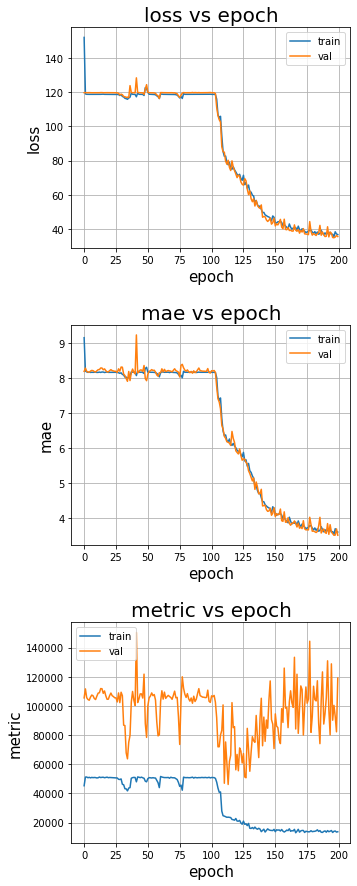

In [50]:
print(H.keys())
# print("loss: ", H["loss"])
# print("mae: ", H["mae"])
# print("val_loss: ", H.history["val_loss"])
# print("val_mae: ", H.history["val_mae"])

lim = 0

fig, ax = plt.subplots(3,1,figsize=(5,15))
fig.subplots_adjust(hspace=0.35)

ax[0].plot(H["loss"][lim:])
ax[0].plot(H["val_loss"][lim:])
ax[0].set_title("loss vs epoch", fontsize=20)
ax[0].set_xlabel("epoch", fontsize=15)
ax[0].set_ylabel("loss", fontsize=15)
ax[0].legend(["train","val"])
ax[0].grid(True)


ax[1].plot(H["mae"][lim:])
ax[1].plot(H["val_mae"][lim:])
ax[1].set_title("mae vs epoch", fontsize=20)
ax[1].set_xlabel("epoch", fontsize=15)
ax[1].set_ylabel("mae", fontsize=15)
ax[1].legend(["train","val"])
ax[1].grid(True)

ax[2].plot(H["customMetric"][lim:])
ax[2].plot(H["val_customMetric"][lim:])
ax[2].set_title("metric vs epoch", fontsize=20)
ax[2].set_xlabel("epoch", fontsize=15)
ax[2].set_ylabel("metric", fontsize=15)
ax[2].legend(["train","val"])
ax[2].grid(True)

model_index -= 1
plt.savefig(gen_name("png"))

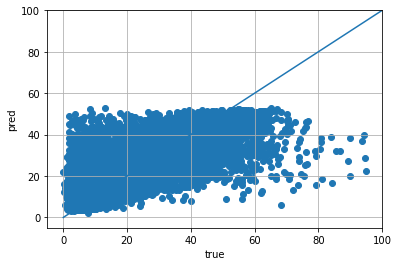

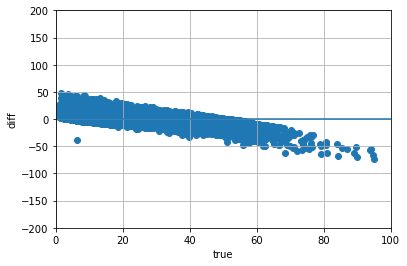

In [51]:
pred = model.predict(x_test)

diff = pred - y_test
plt.scatter(y_test,pred,)
plt.xlabel("true")
plt.ylabel("pred")
plt.plot([0,3000],[0,3000])
plt.grid(True)
# plt.xlim(-10, 1000)
# plt.ylim(-10, 500)
plt.xlim(-5, 100)
plt.ylim(-5, 100)
plt.show()

plt.scatter(y_test,diff)
plt.xlabel("true")
plt.ylabel("diff")
plt.grid(True)
plt.plot([0,3000],[0,0])
plt.xlim(0, 100)
plt.ylim(-200, 200)
plt.show()



(196036, 1)
(196036, 1)


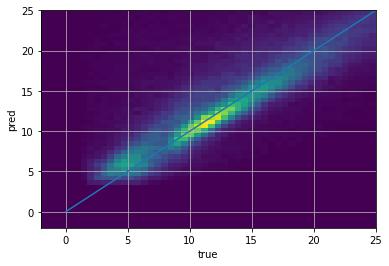

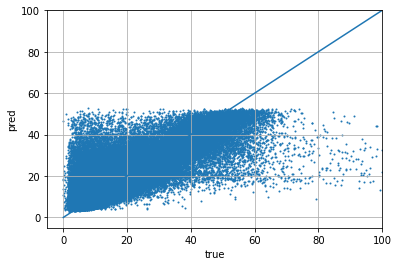

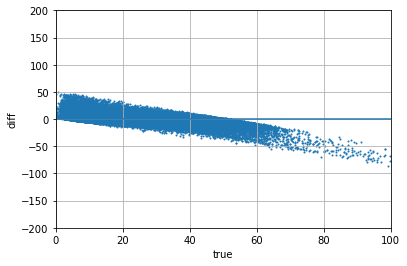

(196036,)
(196036, 1)


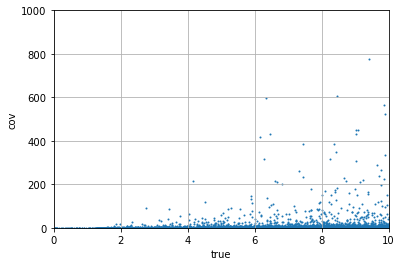

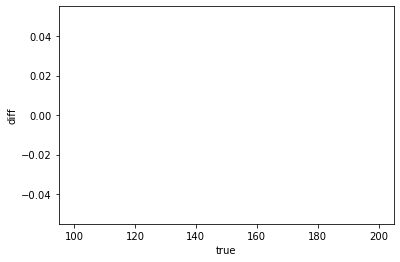

In [54]:
pred = model.predict(x_train)
print(pred.shape)
print(y_train.shape)

diff = pred - y_train
plt.hist2d(y_train[:,0],pred[:,0],bins=[50,50],range=[[-2,25],[-2,25]])
plt.xlabel("true")
plt.ylabel("pred")
plt.plot([0,3000],[0,3000])
plt.grid(True)
# plt.xlim(-10, 1000)
# plt.ylim(-10, 500)
# plt.xlim(-10, 200)
# plt.ylim(-10, 100)
plt.show()


plt.scatter(y_train,pred,s=1)
plt.xlabel("true")
plt.ylabel("pred")
plt.plot([0,3000],[0,3000])
plt.grid(True)
# plt.xlim(-10, 1000)
# plt.ylim(-10, 500)
plt.xlim(-5, 100)
plt.ylim(-5, 100)
plt.show()

plt.scatter(y_train,diff,s=1)
plt.xlabel("true")
plt.ylabel("diff")
plt.grid(True)
plt.plot([0,3000],[0,0])
plt.xlim(0, 100)
plt.ylim(-200, 200)
plt.show()



cov = x_train[2][:,12]
print(cov.shape);
print(y_train.shape)

plt.scatter(y_train[:,0],cov,s=1)
plt.xlabel("true")
plt.ylabel("cov")
plt.grid(True)
# plt.xlim(-10, 1000)
# plt.ylim(-10, 500)
plt.xlim(0, 10)
plt.ylim(0, 1000)
plt.show()


# plt.hist2d(y_train[:,0],diff[:,0],bins=[100,100],range=[[0,200],[-20,20]])
plt.hist(y_train[:,0],bins=100,range=[100,200])
plt.xlabel("true")
plt.ylabel("diff")
# plt.grid(True)
# plt.plot([0,3000],[0,0])
# plt.xlim(0, 00)
# plt.ylim(-1000, 200)
plt.show()


In [53]:
an_array = np.array(list(H.items()))
save_array = np.array([an_array[0][1],an_array[1][1]])
model_index -= 1
np.save(gen_name("npy"),save_array,allow_pickle=True)

# Test Model

In [ ]:
np.set_printoptions(suppress=True, precision=3)
from time import sleep

for i in range(10):
  aax = x_train[0][i:i+1]
  oax = x_train[1][i:i+1]
  cax = x_train[2][i:i+1]
  yax = x_train[3][i:i+1]
  aay = y_train[i][index]
  pred = model.predict([aax, oax, cax, yax])[0][0]
  diff = pred - aay
  # print("i: ",i)
  # print("aax:  ",aax[0,0])
  print("aay:  ",aay)
  print("pred: ",pred)
  # print("diff: ",diff)
  print("")

  # plt.plot(aay[0])
  # plt.plot(pred[0])
  # plt.show()
# [Q/PT, phi, tanl, D, z]


# Load Model

In [18]:
# model.save('drive/MyDrive/RealRNN_1-2-2021_2.h5', save_format="h5")
# model = keras.models.load_model('drive/MyDrive/Models/RealRNN_1-3-2021_300Ep_Onlyphi.h5')
model = keras.models.load_model('models/03-25-2021_tanl-1_loss=22.48.h5')

# Graphs

In [ ]:
print(H.keys())
# print("loss: ", H["loss"])
# print("mae: ", H["mae"])
# print("val_loss: ", H.history["val_loss"])
# print("val_mae: ", H.history["val_mae"])

lim = 0

if len(H.keys()) > 4:
  # fig, ax = plt.subplots(4,1,figsize=(5,20))
  fig, ax = plt.subplots(3,1,figsize=(5,15))
  fig.subplots_adjust(hspace=0.35)

  ax[0].plot(H["loss"][lim:])
  # ax[0].plot(H.history["val_loss"][lim:])
  ax[0].set_title("loss vs epoch", fontsize=20)
  ax[0].set_xlabel("epoch", fontsize=15)
  ax[0].set_ylabel("loss", fontsize=15)
  # ax[0].set_yscale("log")
  ax[0].legend(["train","val"])
  ax[0].grid(True)


  ax[1].plot(H["mae"][lim:])
  # ax[1].plot(H.history["val_mae"][lim:])
  ax[1].set_title("mae vs epoch", fontsize=20)
  ax[1].set_xlabel("epoch", fontsize=15)
  ax[1].set_ylabel("mae", fontsize=15)
  ax[1].legend(["train","val"])
  ax[1].grid(True)

  ax[2].plot(H["q_pt"][lim:])
  ax[2].plot(H["phi"][lim:])
  ax[2].plot(H["tanl"][lim:])
  ax[2].plot(H["D"][lim:])
  ax[2].plot(H["z"][lim:])
  ax[2].set_title("data vs epoch", fontsize=20)
  ax[2].set_xlabel("epoch", fontsize=15)
  ax[2].set_ylabel("data", fontsize=15)
  ax[2].legend(["q_pt","phi","tanl","D","z"])
  # ax[2].legend(["phi","tanl","D","z"])
  # ax[2].legend(["phi","D","z"])
  ax[2].grid(True)

  # ax[3].plot(H.history["val_q_pt"][lim:])
  # ax[3].plot(H.history["val_phi"][lim:])
  # ax[3].plot(H.history["val_tanl"][lim:])
  # ax[3].plot(H.history["val_D"][lim:])
  # ax[3].plot(H.history["val_z"][lim:])
  # ax[3].set_title("data vs epoch", fontsize=20)
  # ax[3].set_xlabel("epoch", fontsize=15)
  # ax[3].set_ylabel("data", fontsize=15)
  # ax[3].legend(["val_q_pt","val_phi","val_tanl","val_D","val_z"])
  # # ax[3].legend(["val_phi","val_tanl","val_D","val_z"])
  # # ax[3].legend(["val_phi","val_D","val_z"])
  # ax[3].grid(True)

else:
  fig, ax = plt.subplots(2,1,figsize=(5,10))
  fig.subplots_adjust(hspace=0.35)

  ax[0].plot(H["loss"][lim:])
  # ax[0].plot(H.history["val_loss"][lim:])
  ax[0].set_title("loss vs epoch", fontsize=20)
  ax[0].set_xlabel("epoch", fontsize=15)
  ax[0].set_ylabel("loss", fontsize=15)
  # ax[0].set_yscale("log")
  ax[0].legend(["train","val"])
  ax[0].grid(True)


  ax[1].plot(H["mae"][lim:])
  # ax[1].plot(H.history["val_mae"][lim:])
  ax[1].set_title("mae vs epoch", fontsize=20)
  ax[1].set_xlabel("epoch", fontsize=15)
  ax[1].set_ylabel("mae", fontsize=15)
  ax[1].legend(["train","val"])
  ax[1].grid(True)


In [ ]:
print(H.history.keys())
print("loss: ", H.history["loss"])
print("mae: ", H.history["mae"])
# print("val_loss: ", H.history["val_loss"])
# print("val_mae: ", H.history["val_mae"])

lim = 2

fig, ax = plt.subplots(2,1,figsize=(5,10))
fig.subplots_adjust(hspace=0.35)

ax[0].plot(H.history["loss"][lim:])
# ax[0].plot(H.history["val_loss"][lim:])
ax[0].set_title("loss vs epoch", fontsize=20)
ax[0].set_xlabel("epoch", fontsize=15)
ax[0].set_ylabel("loss", fontsize=15)
ax[0].set_yscale("log")
ax[0].legend(["train","val"])
ax[0].grid(True)


ax[1].plot(H.history["mae"][lim:])
# ax[1].plot(H.history["val_mae"][lim:])
ax[1].set_title("mae vs epoch", fontsize=20)
ax[1].set_xlabel("epoch", fontsize=15)
ax[1].set_ylabel("mae", fontsize=15)
ax[1].legend(["train","val"])
ax[1].grid(True)


## UV GRAPHS

In [ ]:
x_train[0][0].shape[0] # (event,hits,18)

In [ ]:
from time import sleep
for z in range(10):
    col = 1
    row = 2
#     fig, ax = plt.subplots(row,col,figsize=(5*col,5*row))
    
    fig = plt.figure()
    gs = fig.add_gridspec(row, col, hspace=0, wspace=0)
    ax = gs.subplots(sharex='col', sharey='row')
    
#     fig.subplots_adjust(hspace=0.5)
    u_hits = []
    v_hits = []
    z_hits = []
    for i in range(x_train[0][z].shape[0]):
        u_hits.append(x_train[0][z][i][0])
        v_hits.append(x_train[0][z][i][1])
        z_hits.append(x_train[0][z][i][6])
    ax[0].plot(z_hits,u_hits,"o")
#     ax[0].x_label("z_hits")
#     ax[0].y_label("u_hits")
    ax[1].plot(z_hits,v_hits,"o")
#     ax[1].x_label("z_hits")
#     ax[1].x_label("v_hits")


# Graphs

In [ ]:
# Maybe copy over previous function and edit that?
def graph(pred, true, diff):

  values = ["u","v","sin(v)","cos(v)","sin(u)","cos(u)","s","ds","wire","glayer","z","time","dE_amp","q"]
  limits = [["todo"]]

  size = len(values)

  fig, axs = plt.subplots(4,size,figsize=(size*5,20))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)


  for i in range(size):
    (mu, sigma) = norm.fit(diff[:,i])
    print("data" , values[i] ," |: mu: ", mu, "sigma: " , sigma)
    _, bins, _ = axs[0,i].hist(diff[:,i], 20, density=True)
    y = norm.pdf(bins, mu, sigma)
    l = axs[0,i].plot(bins, y, 'r--', linewidth=2)

    axs[0,i].set_title(values[i] + ' diff')
    axs[0,i].set_ylabel('freq')
    axs[0,i].set_xlabel(values[i] + ' diff')

  #--------------------------------------
  # PREDICTED VS TRUE
  #--------------------------------------
    
  for i in range(size):
    axs[1,i].scatter(true[:,i],pred[:,i])
    axs[1,i].grid(True)

    axs[1,i].set_title(values[i] + ' (predicted vs true)')
    axs[1,i].set_ylabel('pred ' + values[i])
    axs[1,i].set_xlabel('true ' + values[i])

    # axs[1,i].set_xlim(limits[i])
    # axs[1,i].set_ylim(limits[i])
    # axs[1,i].plot(limits[i],limits[i], color='b')

  #--------------------------------------
  # DIFFERENCE VS TRUE
  #--------------------------------------

  for i in range(size):
    axs[2,i].scatter(true[:,i],diff[:,i])
    l, r = axs[2,i].get_xlim()
    axs[2,i].hlines(0, l, r)
    axs[2,i].grid(True)

    axs[2,i].set_title(values[i] + ' (difference vs true)')
    axs[2,i].set_ylabel('diff ' + values[i])
    axs[2,i].set_xlabel('true ' + values[i])

  #--------------------------------------
  # DIFFERENCE VS TRUE 2D HIST
  #--------------------------------------

  for i in range(size):
    axs[3,i].hist2d(true[:,i],diff[:,i],bins=20)

    axs[2,i].set_title(values[i] + ' (difference vs true)')
    axs[2,i].set_ylabel('diff ' + values[i])
    axs[2,i].set_xlabel('true ' + values[i])

  fig.show()


In [ ]:
def gen_test_data(x_test, y_test, size=1000):
  pred = model.predict(x_test)
  diff = pred - y_test
  return pred, y_test, diff

In [ ]:
graph(gen_test_data(x_test, y_test));

# Test model

In [ ]:
# make test function

# Verification of proper data processing

## Using Generator

In [ ]:
aax, aay = next(train_gen)
print(aax.shape)
print(aay.shape)

In [ ]:
print("x",aax[0])
print("y",aay[0])

## Non Genenerator

In [ ]:
for i in range(10):
  aax = x_train[i]
  aay = y_train[i]
  # print(aax.shape)
  # print(aay.shape)
  # print("x",aax)
  print("y",aay)

## Graphs of Data

### filter_ignore

Filters out large and small values and graphs them

In [ ]:
def filter_ignore(var,min=None,max=None,bins=25,ylog=False,xlog=False,cut=True):
  list_ignore = []

  print("--== {} ==--\n".format(var))

  largest = 0
  smallest = 0
  for i in range(len(csv_train[var])):
    if csv_train[var][i] > csv_train[var][largest]:
      largest = i
    if csv_train[var][i] < csv_train[var][smallest]:
      smallest = i
  print("largest value:  ({}, {:.3f})".format(largest,csv_train[var][largest]))
  print("smallest value: ({}, {:.3f})".format(smallest,csv_train[var][smallest]))

  print("")

  if min:
    for i in range(len(csv_train[var])):
      if csv_train[var][i] < min:
        list_ignore.append(i)
    print("min IDs to ignore for '{}':".format(var))
    print(csv_train[var][list_ignore])
    print("")
  if max:
    for i in range(len(csv_train[var])):
      if csv_train[var][i] > max:
        list_ignore.append(i)
    print("max IDs to ignore for '{}':".format(var))
    print(csv_train[var][list_ignore])
    print("")
  if min and max:
    print("total IDs to ignore for '{}':".format(var))
    print(csv_train[var][list_ignore])
    print("")
    plt.hist(csv_train[var],range=[min,max],bins=bins)
  elif min:
    plt.hist(csv_train[var],range=[min,csv_train[var][largest]],bins=bins)
  elif max:
    plt.hist(csv_train[var],range=[csv_train[var][smallest],max],bins=bins)
  else:
    plt.hist(csv_train[var],bins=bins)
  
  plt.title(var)
  if cut:
    plt.xlim(left=min,right=max)
  if ylog:
    plt.yscale("log")
  if xlog:
    plt.xscale("log")
  plt.show()
  return list_ignore

In [ ]:
filter_ignore("q_over_pt",min=-4000,bins=30,ylog=True)

In [ ]:
filter_ignore("tanl",max=1000,bins=25,ylog=True)

In [ ]:
rms_ignore = filter_ignore("rms",max=0.1,bins=25,ylog=True)

In [ ]:
# 'q_over_pt', 'phi', 'tanl', 'D', 'z'
# filter_ignore("D", min=-200, ylog=True,bins=25)
filter_ignore("z",bins=100)

In [ ]:
csv_train.keys()

### 1D Hist of all Data

In [ ]:
plt.hist(csv_train["phi"],bins=50) # -3 to 3, even distrib
plt.title("phi")
plt.show()
# ---
plt.hist(csv_train["D"],range=[-3000,80],bins=25) # -3000 to 50, but val in 65
plt.yscale("log")
plt.title("D")
plt.show()
# ---
plt.hist(csv_train["z"],bins=100)
plt.title("z")
plt.show()

In [ ]:
plt.hist(csv_train["cov_44"],range=[0,1000],bins=25)
# plt.yscale("log")
plt.title("cov_44")
plt.show()

In [ ]:
# fig, ax = plt.subplots(2,1,figsize=(5,10))
# fig.subplots_adjust(hspace=0.35)

plt.hist(csv_train["cov_00"],range=[0,1e8],bins=25) # 0 to 1e13
plt.yscale("log")
plt.title("cov_00")
plt.show()
# ---
plt.hist(csv_train["cov_01"],bins=25) # -1e6 to over 1e5
plt.yscale("log")
plt.title("cov_44")
plt.show()
# ---
plt.hist(csv_train["chisq"],bins=25) # 0 to 200
plt.yscale("log")
plt.title("chisq")
plt.show()
# ---
plt.hist(csv_train["Ndof"],range=[0,44],bins=45) # ? this one weird 0 to ~43
plt.yscale("log")
plt.title("Ndof")
plt.show()
# ---
plt.hist(csv_train["rms"],range=[0,0.1],bins=25) # 
# plt.xscale("log")
plt.yscale("log")
plt.title("rms")
plt.show()
# ---
# plt.hist(csv_train["t_start_cntr"],bins=25) # -60 to ~50
plt.hist(csv_train[csv_train["t_start_cntr_valid"] == 1]["t_start_cntr"],bins=25) # -60 to ~50
plt.title("t_start_cntr")
plt.show()

# plt.hist(csv_train["t_tof"],bins=25) # ~-120 to ~175
plt.hist(csv_train[csv_train["t_tof_valid"] == 1]["t_tof"],bins=25) # ~-120 to ~175
plt.title("t_tof")
plt.show()
plt.hist(csv_train["t_bcal"],bins=25) # ~-22 to 20
plt.title("t_bcal")
plt.show()
plt.hist(csv_train["t_fcal"],bins=25) # ~-100 to ~75
plt.yscale("log")
plt.title("t_fcal")
plt.show()
# ---
plt.hist(csv_train["t_start_cntr_valid"],bins=25) # a lot more 0s
plt.title("t_start_cntr_valid")
plt.show()
plt.hist(csv_train["t_tof_valid"],bins=25) # about 5050
plt.title("t_tof_valid")
plt.show()
plt.hist(csv_train["t_bcal_valid"],bins=25) # almost all 0s
plt.title("t_bcal_valid")
plt.show()
plt.hist(csv_train["t_fcal_valid"],bins=25) # almost all 0s
plt.title("t_fcal_valid")
plt.show()
# ---



### 1D Hist of Hit1 Data

In [ ]:
plt.hist(csv_train["hit1_u"],bins=25) # -42 to 42
plt.title("hit1_u")
plt.show()
plt.hist(csv_train["hit1_v"],bins=25) # -42 to 42
plt.title("hit1_v")
plt.show()
# plt.hist(csv_train["hit1_sinv"],bins=25) # most are 0.96603 almost all are around that though
# plt.title("hit1_sinv")
# plt.show()
# plt.hist(csv_train["hit1_cosv"],bins=25) # most -0.2585
# plt.title("hit1_cosv")
# plt.show()
# plt.hist(csv_train["hit1_sinu"],bins=25) # most 0.96585
# plt.title("hit1_sinu")
# plt.show()
# plt.hist(csv_train["hit1_cosu"],bins=25) # most 0.2591
# plt.title("hit1_cosu")
# plt.show()
plt.hist(csv_train["hit1_s"],bins=25) # -42 to 42
plt.title("hit1_s")
plt.show()
plt.hist(csv_train["hit1_ds"],bins=25) # 0.01 to 0.04
plt.title("hit1_ds")
plt.show()
plt.hist(csv_train["hit1_wire"],bins=101,range=[0,100]) # 0 to 100
plt.title("hit1_wire")
plt.show()
plt.hist(csv_train["hit1_glayer"],bins=25,range=[0,26]) # 6 to 23
plt.title("hit1_glayer")
plt.show()
plt.hist(csv_train["hit1_z"],bins=25) # spaced out between 180 and 340
plt.title("hit1_z")
plt.show()
plt.hist(csv_train["hit1_time"],bins=25) # -75 to 270
plt.title("hit1_time")
plt.show()
plt.hist(csv_train["hit1_dE_amp"],bins=25) # 0 to 2e-7
plt.title("hit1_dE_amp")
plt.show()
plt.hist(csv_train["hit1_q"],bins=25) # 0 to 85
plt.yscale("log")
plt.title("hit1_q")
plt.show()
# ---

### 2D Scatters of various data

In [ ]:
plt.scatter(csv_train["tanl"],abs(csv_train["q_over_pt"]),s=0.01) # a lot more 0s
plt.title("q_over_pt vs tanl")
plt.xlabel("tanl")
plt.ylabel("q_over_pt")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

In [ ]:
# all create a plus sign
plt.scatter(csv_train["t_start_cntr"],csv_train["t_tof"]) # a lot more 0s
plt.title("t_tof vs t_start_cntr")
plt.xlabel("t_start_cntr")
plt.ylabel("t_tof")
plt.show()

# plt.hist(csv_train["t_start_cntr"],bins=25) # -60 to ~50
# plt.hist(csv_train["t_tof"],bins=25) # ~-120 to ~175
# plt.hist(csv_train["t_bcal"],bins=25) # ~-22 to 20
# plt.hist(csv_train["t_fcal"],bins=25) # ~-100 to ~75

In [ ]:
plt.hist(csv_train["hit1_glayer"],bins=24)
plt.hist(csv_train["hit2_glayer"],bins=24)
plt.hist(csv_train["hit3_glayer"],bins=24)
plt.hist(csv_train["hit4_glayer"],bins=24)
plt.hist(csv_train["hit5_glayer"],bins=24)
plt.hist(csv_train["hit6_glayer"],bins=24)
plt.hist(csv_train["hit10_glayer"],bins=24)
plt.show()

### 2D Scatters of various hit data

In [ ]:
# Oval
plt.scatter(csv_train["hit1_u"],csv_train["hit1_v"]) # -3 to 3, even distrib
plt.title("v vs u")
plt.xlabel("u")
plt.ylabel("v")
plt.show()

# like a flame
plt.scatter(csv_train["hit1_s"],csv_train["hit1_ds"]) # -3 to 3, even distrib
plt.title("ds vs s")
plt.xlabel("s")
plt.ylabel("ds")
plt.show()

# hit1_wire, with single letters, forms an oval
plt.scatter(csv_train["hit1_wire"],csv_train["hit1_s"]) # -3 to 3, even distrib
plt.title("hit1_s vs hit1_wire")
plt.xlabel("hit1_wire")
plt.ylabel("hit1_s")
plt.show()

# go up in steps
plt.scatter(csv_train["hit1_glayer"],csv_train["hit1_z"]) # -3 to 3, even distrib
plt.title("z vs glayer")
plt.xlabel("glayer")
plt.ylabel("z")
plt.show()

# 1:1
plt.scatter(csv_train["hit1_q"],csv_train["hit1_dE_amp"]) # -3 to 3, even distrib
plt.title("dE_amp vs q")
plt.xlabel("q")
plt.ylabel("dE_amp")
plt.show()



In [ ]:
aax = 
plt.plot()

# Depricated?

## Non Custom Loss

In [ ]:
# --==Not in use?==--
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.8)

from keras.layers import Dense

nInput = 10

# inputs = keras.layers.Input((None,nInput))
# print("train shape of one batch:", x_train.shape[1:])

# --==Set seed to get identical results==-- begin
# from tensorflow.random import set_seed
# np.random.seed(1)
# set_seed(2)
# --==Set seed to get identical results==-- end


#--==Set Weights==--
# loss_weights = [1/(sd**2)]
# loss_weights = np.array(loss_weights)/sum(loss_weights)
# model.compile(optimizer=optimizer, loss="mse", loss_weights=loss_weights, metrics=["mae"])

inputs = keras.Input((None,nInput),ragged=True)

# --==Choose model==--
# x = model(inputs)
# x = model_timeless(inputs)
# x = RNNTime(inputs)
x = RNNTimeless(inputs)
# x = RNNTimeStateful(inputs)


outs = {
    "q_pt":Dense(1, name="q_pt")(x),
    "phi":Dense(1, name="phi")(x),
    "tanl":Dense(1, name="tanl")(x),
    "D":Dense(1, name="D")(x),
    "z":Dense(1, name="z")(x)
}

y_dict = {
    "q_pt":y_train[:,0],
    "phi":y_train[:,1],
    "tanl":y_train[:,2],
    "D":y_train[:,3],
    "z":y_train[:,4]
}


# model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")
# model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")
model = keras.Model(inputs=inputs, outputs=outs, name="RNNModel")

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=50, mode='min', verbose=1, restore_best_weights=True)
rag_x = x_train[0]
H = model.fit(x=rag_x, y=y_dict, batch_size=64, epochs=100, verbose=1, callbacks=[es])

# Overfit
# es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=100, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=x_train[:10], y=y_train[:10], batch_size=1, epochs=200, verbose=1, shuffle=True, callbacks=[es])

## Versions

### V2

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
#--------------------------------------------
# Define custom loss function 
def customLoss(y_true, y_pred, invcov):
  # print(type(y_true))    #<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


  # print(y_pred)

  y_pred_a = []
  for k in y_pred.keys():
    y_pred_a.append(np.squeeze(y_pred[k]))

  y_pred = np.array(y_pred_a).astype("float64")
  y_pred = tf.transpose(y_pred, perm=(1,0))
  # print(y_pred.shape)
  print(y_pred)

  batch_size = tf.shape(y_pred)[0]
  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred dict shape of each is (batch, 1)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch, 25)
  
  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  invcov = K.reshape(invcov, (batch_size, 5,5)) # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_loss = K.reshape(y_dot, (batch_size, 5))  # y_dot shape is now (batch,5)

  y_dict = {
      "q_pt":y_loss[:,0],
      "phi":y_loss[:,1],
      "tanl":y_loss[:,2],
      "D":y_loss[:,3],
      "z":y_loss[:,4],
  }

  # y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  # y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  # y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  return y_dict
#--------------------------------------------
# Test loss function
# x_test = y_train[0]
x_test = x_train[2][0:4]
y_test = model.predict([x_train[0][0:4],x_train[1][0:4],x_train[2][0:4]])
inconv_test = x_train[1][0:4]

# for k in y_test.keys():
#   y_test[k] = np.squeeze(y_test[k])
# print(y_test)

# print(y_test)
# y_test_a = []
# for k in y_test.keys():
#   y_test_a.append(y_test[k])
# y_test = np.squeeze(np.array(y_test_a))
# print(y_test.shape)
# print(y_test)

# loss = K.eval(customLoss(K.variable([x_test,x_test,x_test]), K.variable([y_test,y_test,y_test]), K.variable([inconv_test,inconv_test,inconv_test])))
loss = K.eval(customLoss(x_test, y_test, inconv_test))
# print('loss shape: '    + str(loss.shape)    )
print(loss)

### V3

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
#--------------------------------------------
# Define custom loss function 
def customLoss(q_pt_true, phi_true, tanl_true, D_true, z_true, q_pt_pred, phi_pred, tanl_pred, D_pred, z_pred, invcov):


  y_pred = [q_pt_pred, phi_pred, tanl_pred, D_pred, z_pred]
  # y_pred = np.array(y_pred).astype("float64")
  y_pred = tf.transpose(y_pred, perm=(1,0))
  y_pred = tf.cast(y_pred, "float64")

  y_true = [q_pt_true, phi_true, tanl_true, D_true, z_true]
  # y_true = np.array(y_true).astype("float64")
  y_true = tf.transpose(y_true, perm=(1,0))
  y_true = tf.cast(y_true, "float64")

  batch_size = tf.shape(y_pred)[0]
  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred dict shape of each is (batch, 1)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch, 25)
  
  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  invcov = K.reshape(invcov, (batch_size, 5,5)) # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_loss = K.reshape(y_dot, (batch_size, 5))  # y_dot shape is now (batch,5)

  y_dict = {
      "q_pt":y_loss[:,0],
      "phi":y_loss[:,1],
      "tanl":y_loss[:,2],
      "D":y_loss[:,3],
      "z":y_loss[:,4],
  }

  # y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  # y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  # y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  return y_dict
#--------------------------------------------
# Test loss function
# x_test = y_train[0]
x_test = x_train[2][0:4]
y_test = model.predict([x_train[0][0:4],x_train[1][0:4],x_train[2][0:4]])
inconv_test = x_train[1][0:4]

y_test_a = []
for k in y_test.keys():
  y_test_a.append(y_test[k])
y_test = np.squeeze(np.array(y_test_a))
y_test = np.swapaxes(y_test, 0, 1)
print(y_test.shape)


# loss = K.eval(customLoss(K.variable([x_test,x_test,x_test]), K.variable([y_test,y_test,y_test]), K.variable([inconv_test,inconv_test,inconv_test])))
loss = K.eval(customLoss(x_test[:,0],x_test[:,1],x_test[:,2],x_test[:,3],x_test[:,4], y_test[:,0], y_test[:,1],y_test[:,2],y_test[:,3],y_test[:,4], inconv_test))
# print('loss shape: '    + str(loss.shape)    )
print(loss)

### V4

So, we have the prediction and true vector

$$
y_{pred}=
\begin{bmatrix}
q\_pt \\ phi \\ tanl \\ D \\ z
\end{bmatrix}
$$

We have the inverse covariance matrix, we'll label it $C^{-1}$:

and $y_p = y_{predict}$

$$
C^{-1} = 
\begin{bmatrix}
qq & qp & qt & qd & qz \\
qp & pp & pt & pd & pz \\
qt & pt & tt & td & tz \\
qd & pd & td & dd & dz \\
qz & pz & tz & dz & zz \\
\end{bmatrix}
$$

Thus, the formula before was:

$$
loss = C^{-1} \cdot \vec{y_p}  \cdot \vec{y_p}
$$

$$
  y_{dot} =
  \begin{bmatrix}
    qq & qp & qt & qd & qz \\
    qp & pp & pt & pd & pz \\
    qt & pt & tt & td & tz \\
    qd & pd & td & dd & dz \\
    qz & pz & tz & dz & zz 
  \end{bmatrix} 
  \cdot
  \begin{bmatrix}
    q\_pt \\ phi \\ tanl \\ D \\ z
  \end{bmatrix}
$$

$$
  y_{dot} = 
  \begin{bmatrix}
    qq*q\_pt + qp*phi + qt*tanl + qd*D + qz*z \\
    qp*q\_pt + pp*phi + pt*tanl + pd*D + pz*z \\
    qt*q\_pt + pt*phi + tt*tanl + td*D + tz*z \\
    qd*q\_pt + pd*phi + td*tanl + dd*D + dz*z \\
    qz*q\_pt + dz*phi + tz*tanl + pz*D + zz*z
  \end{bmatrix}
$$

---

Now, working on the output split for each variable, im looking for ways to seperate the variables after that operation.
So maybe just sum the q_pt column of the matrix and multiply by q_pt?

Maybe this would work? :

$$
loss_{q\_pt} =  y_p^{q\_pt} * \sum_{i=0}^{4} C^{-1}_{qi}
$$

Where $C^{-1}_q$ is one row or column of the matrix of that variable





In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
#--------------------------------------------
# Define custom loss function 
def customLoss(y_true, y_pred, invcov):
  # print(type(y_true))    #<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>

  # print(y_pred)

  # Theoretically:
  # K.dot(invcov[0,:] * q_pt,q_pt)    # ?
  


  y_pred_a = []
  for k in y_pred.keys():
    y_pred_a.append(np.squeeze(y_pred[k]))

  y_pred = np.array(y_pred_a).astype("float64")
  y_pred = tf.transpose(y_pred, perm=(1,0))
  # print(y_pred.shape)
  print(y_pred)

  batch_size = tf.shape(y_pred)[0]
  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred dict shape of each is (batch, 1)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch, 25)
  
  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  invcov = K.reshape(invcov, (batch_size, 5,5)) # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_loss = K.reshape(y_dot, (batch_size, 5))  # y_dot shape is now (batch,5)

  y_dict = {
      "q_pt":y_loss[:,0],
      "phi":y_loss[:,1],
      "tanl":y_loss[:,2],
      "D":y_loss[:,3],
      "z":y_loss[:,4],
  }

  # y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  # y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  # y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  return y_dict
#--------------------------------------------
# Test loss function
# x_test = y_train[0]
x_test = x_train[2][0:4]
y_test = model.predict([x_train[0][0:4],x_train[1][0:4],x_train[2][0:4]])
inconv_test = x_train[1][0:4]

# for k in y_test.keys():
#   y_test[k] = np.squeeze(y_test[k])
# print(y_test)

# print(y_test)
# y_test_a = []
# for k in y_test.keys():
#   y_test_a.append(y_test[k])
# y_test = np.squeeze(np.array(y_test_a))
# print(y_test.shape)
# print(y_test)

# loss = K.eval(customLoss(K.variable([x_test,x_test,x_test]), K.variable([y_test,y_test,y_test]), K.variable([inconv_test,inconv_test,inconv_test])))
loss = K.eval(customLoss(x_test, y_test, inconv_test))
# print('loss shape: '    + str(loss.shape)    )
print(loss)

### V5 unedited

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
#--------------------------------------------
# Define custom loss function 
def customLoss(y_true, y_pred, invcov):
  # print(type(y_true))    #<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>

  batch_size = tf.shape(y_pred)[0]
  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred shape is (batch, 5)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch, 25)
  
  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  invcov = K.reshape(invcov, (batch_size, 5,5)) # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  # y_dict = {
  #     "q_pt":y_diff[0]*y_diff[0],
  #     "phi":y_diff[0]*y_diff[0]
  # }
  # y_diff[0] / invcov[0][0]
  return y_loss

#--------------------------------------------
# Test loss function
# x_test = x_train[2][0]
# y_test = model.predict([x_train[0][0:1],x_train[1][0:1],x_train[2][0:1]])
# y_test = np.squeeze(y_test)
# inconv_test = x_train[1][0]

# loss = K.eval(customLoss(K.variable([x_test,x_test,x_test]), K.variable([y_test,y_test,y_test]), K.variable([inconv_test,inconv_test,inconv_test])))
# # print('loss shape: '    + str(loss.shape)    )
# print(loss)

### V6 New Way

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
def customLoss(m_invcov):
  def customLoss_fn(y_true, y_pred):
    batch_size = tf.shape(y_pred)[0]

    y_pred = tf.cast(K.reshape(y_pred, (batch_size, 5,1)),"float64") # y_pred  shape is now (batch, 5,1)
    y_true = tf.cast(K.reshape(y_true, (batch_size, 5,1)),"float64") # y_state shape is now (batch, 5,1)
    invcov = tf.cast(K.reshape(m_invcov, (batch_size, 5,5)),"float64") # invcov  shape is now (batch, 5,5)
    
    # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
    invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
    
    # Difference between prediction and true state vectors
    y_diff = y_pred - y_true

    # n.b. use "batch_dot" and not "dot"!
    y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
    y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
    y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
    y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
    return y_loss
  return customLoss_fn

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
def customLoss(y_true, y_pred, invcov):
  batch_size = tf.shape(y_pred)[0]

  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred shape is (batch, 5)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch, 25)

  y_pred = tf.cast(K.reshape(y_pred, (batch_size, 5,1)),"float64") # y_pred  shape is now (batch, 5,1)
  y_true = tf.cast(K.reshape(y_true, (batch_size, 5,1)),"float64") # y_state shape is now (batch, 5,1)
  invcov = tf.cast(K.reshape(invcov, (batch_size, 5,5)),"float64") # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  return y_loss